# 初始化

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')  # 返回notebook的上一级目录
# sys.path.append('E:\GitHub\QA-abstract-and-reasoning')  # 效果同上

In [2]:
# 在google colab运行则执行以下代码
try:
    from google.colab import drive
    drive_path = '/content/drive'
    working_path = drive_path + "/My Drive/QA" # 工作路径
    drive.mount(drive_path)
    os.chdir(working_path)
    sys.path.append(working_path)  # 环境变量
    print("current working directory: ", os.getcwd())
    
    # %tensorflow_version 仅存在于 Colab
    %tensorflow_version 2.x
    print("run notebook in colab")
except:
    print("no colab")

no colab


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
np.set_printoptions(suppress=True)
from utils.plot import plot_attention
from utils.saveLoader import *
from utils.config import *
from layers import *
from preprocess import Preprocess
from gensim.models.word2vec import LineSentence, Word2Vec
import tensorflow as tf
# from model_layer import seq2seq_model
import time
tf.__version__

'2.0.0'

[限制gpu内存增长](https://tensorflow.google.cn/guide/gpu#limiting_gpu_memory_growth)

In [4]:
from utils.config_gpu import config_gpu
config_gpu()

1 Physical GPUs, 1 Logical GPUs


## 加载数据

In [5]:
train_x,train_y,test_x = load_train_dataset()  # 数据集
vocab,vocab_reversed = load_vocab(VOCAB_PAD)  # vocab
embedding_matrix = np.loadtxt(EMBEDDING_MATRIX_PAD)  # 预训练层

## 设置参数

In [6]:
params = {}
params["vocab_size"] = len(vocab)
params["max_enc_len"] = train_x.shape[1]  # 260
params["max_dec_len"] = train_y.shape[1]  # 33
params["embed_size"] = embedding_matrix.shape[1]
params["enc_units"] = 256
params["attn_units"] = 10
params["dec_units"] = params["enc_units"]
params["batch_size"] = 32
params["epochs"] = 2
print(params)

{'vocab_size': 32566, 'max_enc_len': 260, 'max_dec_len': 33, 'embed_size': 300, 'enc_units': 256, 'attn_units': 10, 'dec_units': 256, 'batch_size': 32, 'epochs': 2}


## 构建训练集

In [7]:
# 取部分数据进行训练
# sample_num=64
sample_num = train_x.shape[0]
dataset = tf.data.Dataset.from_tensor_slices((train_x[:sample_num], train_y[:sample_num])).shuffle(params["batch_size"]*2+1)
dataset = dataset.batch(params["batch_size"], drop_remainder=True)

In [8]:
steps_per_epoch = sample_num//params["batch_size"]

## 构建模型

In [9]:
from seq2seq import *
model=Seq2Seq(params)

## 保存点设置

In [10]:
from utils.config import CKPT_DIR, CKPT_PREFIX
from utils.saveLoader import del_all_files_of_dir
ckpt = tf.train.Checkpoint(Seq2Seq=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, CKPT_DIR, max_to_keep=5)

In [11]:
del_all_files_of_dir(CKPT_DIR)
ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

there no files in this path
Model restored


## 训练

[SparseCategoricalCrossentropy](https://tensorflow.google.cn/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)

In [12]:
optimizer = tf.keras.optimizers.Adam(name='Adam',learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

pad_index=vocab['<PAD>']
unk_index=vocab['<UNK>']

def loss_function(real, pred):
    pad_mask = tf.math.equal(real, pad_index)
    unk_mask = tf.math.equal(real, unk_index)
    # <PAD> 和 <UNK> 的损失都不算
    mask = tf.math.logical_not(tf.math.logical_or(pad_mask,unk_mask))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)
    # return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
# 调试train_step()
# inp, targ = next(iter(dataset))
# pad_index=vocab['<PAD>']
# unk_index=vocab['<UNK>']
# enc_output, enc_hidden = model.call_encoder(inp)
# dec_hidden = enc_hidden
# dec_input = tf.expand_dims([vocab['<START>']] * params["batch_size"], 1)
# predictions, _ = model(dec_input, dec_hidden, enc_output, targ)

In [13]:
@tf.function
def train_step(inp, targ):
    pad_index=vocab['<PAD>']
    unk_index=vocab['<UNK>']
    loss = 0
    
    with tf.GradientTape() as tape:
        # 1. 构建encoder
        enc_output, enc_hidden = model.call_encoder(inp)
        # 2. 复制
        dec_hidden = enc_hidden
        # 3. <START> * BATCH_SIZE 
        dec_input = tf.expand_dims([vocab['<START>']] * params["batch_size"], 1)
        
        # 逐个预测序列
        predictions, _ = model(dec_input, dec_hidden, enc_output, targ)
        
        batch_loss = loss_function(targ[:, 1:], predictions)

        variables = model.encoder.trainable_variables + model.decoder.trainable_variables+ model.attention.trainable_variables
    
        gradients = tape.gradient(batch_loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [14]:
epochs = params["epochs"]
# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    
for epoch in range(epochs):
    start = time.time()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch+1)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss

        if batch % 1 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.3902
Epoch 1 Batch 1 Loss 5.6638
Epoch 1 Batch 2 Loss 5.2197
Epoch 1 Batch 3 Loss 5.5543
Epoch 1 Batch 4 Loss 5.8169
Epoch 1 Batch 5 Loss 4.5870
Epoch 1 Batch 6 Loss 5.0880
Epoch 1 Batch 7 Loss 4.8601
Epoch 1 Batch 8 Loss 4.3980
Epoch 1 Batch 9 Loss 3.2799
Epoch 1 Batch 10 Loss 5.2775
Epoch 1 Batch 11 Loss 3.6353
Epoch 1 Batch 12 Loss 2.7170
Epoch 1 Batch 13 Loss 2.6421
Epoch 1 Batch 14 Loss 2.1167
Epoch 1 Batch 15 Loss 2.9356
Epoch 1 Batch 16 Loss 2.4914
Epoch 1 Batch 17 Loss 2.3527
Epoch 1 Batch 18 Loss 2.4934
Epoch 1 Batch 19 Loss 3.1829
Epoch 1 Batch 20 Loss 3.3698
Epoch 1 Batch 21 Loss 3.2792
Epoch 1 Batch 22 Loss 3.1758
Epoch 1 Batch 23 Loss 3.3565
Epoch 1 Batch 24 Loss 2.8799
Epoch 1 Batch 25 Loss 2.5533
Epoch 1 Batch 26 Loss 2.5327
Epoch 1 Batch 27 Loss 3.1751
Epoch 1 Batch 28 Loss 3.1140
Epoch 1 Batch 29 Loss 2.9614
Epoch 1 Batch 30 Loss 3.0480
Epoch 1 Batch 31 Loss 3.4621
Epoch 1 Batch 32 Loss 3.3694
Epoch 1 Batch 33 Loss 2.5887
Epoch 1 Batch 34 Loss 1.

Epoch 1 Batch 277 Loss 2.5332
Epoch 1 Batch 278 Loss 2.7266
Epoch 1 Batch 279 Loss 2.2328
Epoch 1 Batch 280 Loss 2.3626
Epoch 1 Batch 281 Loss 2.8816
Epoch 1 Batch 282 Loss 2.6482
Epoch 1 Batch 283 Loss 2.3508
Epoch 1 Batch 284 Loss 2.4148
Epoch 1 Batch 285 Loss 2.1364
Epoch 1 Batch 286 Loss 1.7620
Epoch 1 Batch 287 Loss 2.5446
Epoch 1 Batch 288 Loss 1.9034
Epoch 1 Batch 289 Loss 2.3294
Epoch 1 Batch 290 Loss 2.4867
Epoch 1 Batch 291 Loss 2.5074
Epoch 1 Batch 292 Loss 1.7173
Epoch 1 Batch 293 Loss 2.1615
Epoch 1 Batch 294 Loss 2.1000
Epoch 1 Batch 295 Loss 2.4031
Epoch 1 Batch 296 Loss 1.9260
Epoch 1 Batch 297 Loss 2.8261
Epoch 1 Batch 298 Loss 2.3688
Epoch 1 Batch 299 Loss 2.1287
Epoch 1 Batch 300 Loss 2.3126
Epoch 1 Batch 301 Loss 2.2815
Epoch 1 Batch 302 Loss 1.7520
Epoch 1 Batch 303 Loss 2.2485
Epoch 1 Batch 304 Loss 1.6329
Epoch 1 Batch 305 Loss 2.2861
Epoch 1 Batch 306 Loss 2.0162
Epoch 1 Batch 307 Loss 2.9728
Epoch 1 Batch 308 Loss 2.4058
Epoch 1 Batch 309 Loss 2.5699
Epoch 1 Ba

Epoch 1 Batch 551 Loss 2.6761
Epoch 1 Batch 552 Loss 1.9607
Epoch 1 Batch 553 Loss 2.0225
Epoch 1 Batch 554 Loss 2.1884
Epoch 1 Batch 555 Loss 2.5218
Epoch 1 Batch 556 Loss 2.4330
Epoch 1 Batch 557 Loss 1.8679
Epoch 1 Batch 558 Loss 2.0639
Epoch 1 Batch 559 Loss 1.8311
Epoch 1 Batch 560 Loss 2.3148
Epoch 1 Batch 561 Loss 2.3147
Epoch 1 Batch 562 Loss 2.2757
Epoch 1 Batch 563 Loss 2.4726
Epoch 1 Batch 564 Loss 2.0322
Epoch 1 Batch 565 Loss 1.7358
Epoch 1 Batch 566 Loss 2.1908
Epoch 1 Batch 567 Loss 2.1499
Epoch 1 Batch 568 Loss 2.1539
Epoch 1 Batch 569 Loss 2.2235
Epoch 1 Batch 570 Loss 1.9656
Epoch 1 Batch 571 Loss 1.3884
Epoch 1 Batch 572 Loss 1.8819
Epoch 1 Batch 573 Loss 2.0066
Epoch 1 Batch 574 Loss 1.9259
Epoch 1 Batch 575 Loss 2.5262
Epoch 1 Batch 576 Loss 1.9042
Epoch 1 Batch 577 Loss 2.5569
Epoch 1 Batch 578 Loss 2.8194
Epoch 1 Batch 579 Loss 2.4888
Epoch 1 Batch 580 Loss 2.0708
Epoch 1 Batch 581 Loss 2.2200
Epoch 1 Batch 582 Loss 2.2083
Epoch 1 Batch 583 Loss 2.0884
Epoch 1 Ba

Epoch 1 Batch 825 Loss 1.9037
Epoch 1 Batch 826 Loss 1.8563
Epoch 1 Batch 827 Loss 2.2698
Epoch 1 Batch 828 Loss 2.5655
Epoch 1 Batch 829 Loss 2.5596
Epoch 1 Batch 830 Loss 2.7183
Epoch 1 Batch 831 Loss 2.0226
Epoch 1 Batch 832 Loss 2.5239
Epoch 1 Batch 833 Loss 2.3136
Epoch 1 Batch 834 Loss 1.6843
Epoch 1 Batch 835 Loss 1.6242
Epoch 1 Batch 836 Loss 1.9309
Epoch 1 Batch 837 Loss 2.4837
Epoch 1 Batch 838 Loss 1.6524
Epoch 1 Batch 839 Loss 2.0247
Epoch 1 Batch 840 Loss 2.6685
Epoch 1 Batch 841 Loss 1.9771
Epoch 1 Batch 842 Loss 2.3563
Epoch 1 Batch 843 Loss 1.8486
Epoch 1 Batch 844 Loss 2.1735
Epoch 1 Batch 845 Loss 2.1388
Epoch 1 Batch 846 Loss 1.9321
Epoch 1 Batch 847 Loss 2.4017
Epoch 1 Batch 848 Loss 1.9556
Epoch 1 Batch 849 Loss 2.3698
Epoch 1 Batch 850 Loss 1.8454
Epoch 1 Batch 851 Loss 1.6663
Epoch 1 Batch 852 Loss 2.5039
Epoch 1 Batch 853 Loss 2.2818
Epoch 1 Batch 854 Loss 1.8737
Epoch 1 Batch 855 Loss 1.7481
Epoch 1 Batch 856 Loss 2.0495
Epoch 1 Batch 857 Loss 1.8471
Epoch 1 Ba

Epoch 1 Batch 1096 Loss 1.7915
Epoch 1 Batch 1097 Loss 2.6636
Epoch 1 Batch 1098 Loss 2.0838
Epoch 1 Batch 1099 Loss 1.6486
Epoch 1 Batch 1100 Loss 1.9225
Epoch 1 Batch 1101 Loss 2.3268
Epoch 1 Batch 1102 Loss 2.0157
Epoch 1 Batch 1103 Loss 1.8252
Epoch 1 Batch 1104 Loss 1.6602
Epoch 1 Batch 1105 Loss 2.9506
Epoch 1 Batch 1106 Loss 2.1040
Epoch 1 Batch 1107 Loss 2.4910
Epoch 1 Batch 1108 Loss 2.3540
Epoch 1 Batch 1109 Loss 2.4920
Epoch 1 Batch 1110 Loss 2.1440
Epoch 1 Batch 1111 Loss 2.1032
Epoch 1 Batch 1112 Loss 2.1167
Epoch 1 Batch 1113 Loss 2.0426
Epoch 1 Batch 1114 Loss 1.8764
Epoch 1 Batch 1115 Loss 1.9492
Epoch 1 Batch 1116 Loss 1.5873
Epoch 1 Batch 1117 Loss 2.4339
Epoch 1 Batch 1118 Loss 2.0819
Epoch 1 Batch 1119 Loss 2.4672
Epoch 1 Batch 1120 Loss 2.6624
Epoch 1 Batch 1121 Loss 2.3443
Epoch 1 Batch 1122 Loss 2.2766
Epoch 1 Batch 1123 Loss 1.8444
Epoch 1 Batch 1124 Loss 1.6928
Epoch 1 Batch 1125 Loss 3.0692
Epoch 1 Batch 1126 Loss 2.2562
Epoch 1 Batch 1127 Loss 2.1034
Epoch 1 

Epoch 1 Batch 1362 Loss 1.9632
Epoch 1 Batch 1363 Loss 1.6795
Epoch 1 Batch 1364 Loss 1.9489
Epoch 1 Batch 1365 Loss 2.0493
Epoch 1 Batch 1366 Loss 1.6988
Epoch 1 Batch 1367 Loss 1.8401
Epoch 1 Batch 1368 Loss 1.9432
Epoch 1 Batch 1369 Loss 1.7475
Epoch 1 Batch 1370 Loss 2.1460
Epoch 1 Batch 1371 Loss 1.8751
Epoch 1 Batch 1372 Loss 1.9177
Epoch 1 Batch 1373 Loss 2.3582
Epoch 1 Batch 1374 Loss 1.7523
Epoch 1 Batch 1375 Loss 1.7484
Epoch 1 Batch 1376 Loss 1.3145
Epoch 1 Batch 1377 Loss 1.3935
Epoch 1 Batch 1378 Loss 2.1444
Epoch 1 Batch 1379 Loss 1.7559
Epoch 1 Batch 1380 Loss 2.3757
Epoch 1 Batch 1381 Loss 1.8689
Epoch 1 Batch 1382 Loss 2.1919
Epoch 1 Batch 1383 Loss 1.6612
Epoch 1 Batch 1384 Loss 1.9096
Epoch 1 Batch 1385 Loss 1.9356
Epoch 1 Batch 1386 Loss 2.3608
Epoch 1 Batch 1387 Loss 1.9628
Epoch 1 Batch 1388 Loss 1.8582
Epoch 1 Batch 1389 Loss 1.9530
Epoch 1 Batch 1390 Loss 2.3008
Epoch 1 Batch 1391 Loss 2.1124
Epoch 1 Batch 1392 Loss 2.2307
Epoch 1 Batch 1393 Loss 1.8756
Epoch 1 

Epoch 1 Batch 1628 Loss 2.2402
Epoch 1 Batch 1629 Loss 2.4539
Epoch 1 Batch 1630 Loss 2.2677
Epoch 1 Batch 1631 Loss 2.5801
Epoch 1 Batch 1632 Loss 2.4203
Epoch 1 Batch 1633 Loss 2.3459
Epoch 1 Batch 1634 Loss 2.1286
Epoch 1 Batch 1635 Loss 2.3522
Epoch 1 Batch 1636 Loss 2.5011
Epoch 1 Batch 1637 Loss 2.0897
Epoch 1 Batch 1638 Loss 1.8526
Epoch 1 Batch 1639 Loss 1.9455
Epoch 1 Batch 1640 Loss 2.1454
Epoch 1 Batch 1641 Loss 2.0558
Epoch 1 Batch 1642 Loss 1.8441
Epoch 1 Batch 1643 Loss 1.7983
Epoch 1 Batch 1644 Loss 2.0393
Epoch 1 Batch 1645 Loss 1.4502
Epoch 1 Batch 1646 Loss 1.2929
Epoch 1 Batch 1647 Loss 1.7680
Epoch 1 Batch 1648 Loss 1.2480
Epoch 1 Batch 1649 Loss 1.9367
Epoch 1 Batch 1650 Loss 2.4431
Epoch 1 Batch 1651 Loss 1.9504
Epoch 1 Batch 1652 Loss 1.8370
Epoch 1 Batch 1653 Loss 2.1239
Epoch 1 Batch 1654 Loss 1.7442
Epoch 1 Batch 1655 Loss 2.2609
Epoch 1 Batch 1656 Loss 1.7002
Epoch 1 Batch 1657 Loss 2.3983
Epoch 1 Batch 1658 Loss 2.4690
Epoch 1 Batch 1659 Loss 2.1590
Epoch 1 

Epoch 1 Batch 1893 Loss 1.2295
Epoch 1 Batch 1894 Loss 1.8127
Epoch 1 Batch 1895 Loss 1.7397
Epoch 1 Batch 1896 Loss 1.7049
Epoch 1 Batch 1897 Loss 2.0696
Epoch 1 Batch 1898 Loss 2.3105
Epoch 1 Batch 1899 Loss 2.0449
Epoch 1 Batch 1900 Loss 1.6538
Epoch 1 Batch 1901 Loss 1.9251
Epoch 1 Batch 1902 Loss 2.2535
Epoch 1 Batch 1903 Loss 2.2247
Epoch 1 Batch 1904 Loss 2.4726
Epoch 1 Batch 1905 Loss 2.2299
Epoch 1 Batch 1906 Loss 2.0551
Epoch 1 Batch 1907 Loss 2.3703
Epoch 1 Batch 1908 Loss 2.5753
Epoch 1 Batch 1909 Loss 2.5692
Epoch 1 Batch 1910 Loss 2.2339
Epoch 1 Batch 1911 Loss 1.8068
Epoch 1 Batch 1912 Loss 3.2892
Epoch 1 Batch 1913 Loss 2.1539
Epoch 1 Batch 1914 Loss 2.2837
Epoch 1 Batch 1915 Loss 2.6217
Epoch 1 Batch 1916 Loss 2.3346
Epoch 1 Batch 1917 Loss 2.0129
Epoch 1 Batch 1918 Loss 1.4536
Epoch 1 Batch 1919 Loss 1.9354
Epoch 1 Batch 1920 Loss 1.6419
Epoch 1 Batch 1921 Loss 2.3058
Epoch 1 Batch 1922 Loss 2.3742
Epoch 1 Batch 1923 Loss 1.8754
Epoch 1 Batch 1924 Loss 1.9236
Epoch 1 

Epoch 1 Batch 2158 Loss 2.3884
Epoch 1 Batch 2159 Loss 2.5296
Epoch 1 Batch 2160 Loss 2.2438
Epoch 1 Batch 2161 Loss 1.7272
Epoch 1 Batch 2162 Loss 1.5775
Epoch 1 Batch 2163 Loss 1.7755
Epoch 1 Batch 2164 Loss 3.1757
Epoch 1 Batch 2165 Loss 1.9436
Epoch 1 Batch 2166 Loss 2.2336
Epoch 1 Batch 2167 Loss 2.2795
Epoch 1 Batch 2168 Loss 1.6203
Epoch 1 Batch 2169 Loss 1.6064
Epoch 1 Batch 2170 Loss 1.9728
Epoch 1 Batch 2171 Loss 1.9386
Epoch 1 Batch 2172 Loss 2.1502
Epoch 1 Batch 2173 Loss 1.5305
Epoch 1 Batch 2174 Loss 2.1126
Epoch 1 Batch 2175 Loss 1.6977
Epoch 1 Batch 2176 Loss 2.2159
Epoch 1 Batch 2177 Loss 1.8575
Epoch 1 Batch 2178 Loss 2.2587
Epoch 1 Batch 2179 Loss 2.5771
Epoch 1 Batch 2180 Loss 1.9621
Epoch 1 Batch 2181 Loss 2.2215
Epoch 1 Batch 2182 Loss 2.2129
Epoch 1 Batch 2183 Loss 1.9554
Epoch 1 Batch 2184 Loss 2.0689
Epoch 1 Batch 2185 Loss 2.1403
Epoch 1 Batch 2186 Loss 1.9843
Epoch 1 Batch 2187 Loss 2.0082
Epoch 1 Batch 2188 Loss 1.6618
Epoch 1 Batch 2189 Loss 1.6455
Epoch 1 

Epoch 1 Batch 2423 Loss 1.7813
Epoch 1 Batch 2424 Loss 1.8407
Epoch 1 Batch 2425 Loss 1.8700
Epoch 1 Batch 2426 Loss 1.5934
Epoch 1 Batch 2427 Loss 2.0567
Epoch 1 Batch 2428 Loss 1.9167
Epoch 1 Batch 2429 Loss 1.6275
Epoch 1 Batch 2430 Loss 1.2497
Epoch 1 Batch 2431 Loss 1.2487
Epoch 1 Batch 2432 Loss 1.7100
Epoch 1 Batch 2433 Loss 1.6126
Epoch 1 Batch 2434 Loss 1.4995
Epoch 1 Batch 2435 Loss 1.2786
Epoch 1 Batch 2436 Loss 1.6552
Epoch 1 Batch 2437 Loss 1.7767
Epoch 1 Batch 2438 Loss 1.6656
Epoch 1 Batch 2439 Loss 1.9592
Epoch 1 Batch 2440 Loss 1.5365
Epoch 1 Batch 2441 Loss 1.4588
Epoch 1 Batch 2442 Loss 1.4257
Epoch 1 Batch 2443 Loss 1.3978
Epoch 1 Batch 2444 Loss 1.6049
Epoch 1 Batch 2445 Loss 1.6749
Epoch 1 Batch 2446 Loss 1.5781
Epoch 1 Batch 2447 Loss 1.5970
Epoch 1 Batch 2448 Loss 1.5103
Epoch 1 Batch 2449 Loss 1.4395
Epoch 1 Batch 2450 Loss 1.7926
Epoch 1 Batch 2451 Loss 1.8084
Epoch 1 Batch 2452 Loss 2.7646
Epoch 1 Batch 2453 Loss 2.4109
Epoch 1 Batch 2454 Loss 2.1096
Epoch 1 

Epoch 2 Batch 102 Loss 2.2204
Epoch 2 Batch 103 Loss 2.1744
Epoch 2 Batch 104 Loss 2.0980
Epoch 2 Batch 105 Loss 1.9441
Epoch 2 Batch 106 Loss 2.1995
Epoch 2 Batch 107 Loss 1.9849
Epoch 2 Batch 108 Loss 2.2588
Epoch 2 Batch 109 Loss 1.5151
Epoch 2 Batch 110 Loss 1.4219
Epoch 2 Batch 111 Loss 1.2025
Epoch 2 Batch 112 Loss 1.8161
Epoch 2 Batch 113 Loss 1.8331
Epoch 2 Batch 114 Loss 1.8259
Epoch 2 Batch 115 Loss 1.8014
Epoch 2 Batch 116 Loss 2.0393
Epoch 2 Batch 117 Loss 2.0928
Epoch 2 Batch 118 Loss 1.7953
Epoch 2 Batch 119 Loss 1.6497
Epoch 2 Batch 120 Loss 1.7831
Epoch 2 Batch 121 Loss 1.7864
Epoch 2 Batch 122 Loss 1.9396
Epoch 2 Batch 123 Loss 1.5450
Epoch 2 Batch 124 Loss 1.6809
Epoch 2 Batch 125 Loss 1.5374
Epoch 2 Batch 126 Loss 1.2471
Epoch 2 Batch 127 Loss 1.6255
Epoch 2 Batch 128 Loss 1.3429
Epoch 2 Batch 129 Loss 2.0075
Epoch 2 Batch 130 Loss 1.8124
Epoch 2 Batch 131 Loss 1.7176
Epoch 2 Batch 132 Loss 1.6227
Epoch 2 Batch 133 Loss 1.6996
Epoch 2 Batch 134 Loss 2.6204
Epoch 2 Ba

Epoch 2 Batch 376 Loss 1.3456
Epoch 2 Batch 377 Loss 1.6116
Epoch 2 Batch 378 Loss 1.3551
Epoch 2 Batch 379 Loss 1.7152
Epoch 2 Batch 380 Loss 1.4750
Epoch 2 Batch 381 Loss 1.7426
Epoch 2 Batch 382 Loss 1.5536
Epoch 2 Batch 383 Loss 1.7262
Epoch 2 Batch 384 Loss 1.8879
Epoch 2 Batch 385 Loss 1.3849
Epoch 2 Batch 386 Loss 1.5156
Epoch 2 Batch 387 Loss 1.7760
Epoch 2 Batch 388 Loss 1.6486
Epoch 2 Batch 389 Loss 1.4967
Epoch 2 Batch 390 Loss 1.5318
Epoch 2 Batch 391 Loss 1.9993
Epoch 2 Batch 392 Loss 2.0936
Epoch 2 Batch 393 Loss 1.6048
Epoch 2 Batch 394 Loss 1.4842
Epoch 2 Batch 395 Loss 1.6104
Epoch 2 Batch 396 Loss 1.4105
Epoch 2 Batch 397 Loss 1.5293
Epoch 2 Batch 398 Loss 1.4847
Epoch 2 Batch 399 Loss 1.8645
Epoch 2 Batch 400 Loss 2.2639
Epoch 2 Batch 401 Loss 1.4083
Epoch 2 Batch 402 Loss 0.9536
Epoch 2 Batch 403 Loss 1.4660
Epoch 2 Batch 404 Loss 1.9468
Epoch 2 Batch 405 Loss 1.3354
Epoch 2 Batch 406 Loss 1.6067
Epoch 2 Batch 407 Loss 2.1680
Epoch 2 Batch 408 Loss 2.0339
Epoch 2 Ba

Epoch 2 Batch 651 Loss 1.9376
Epoch 2 Batch 652 Loss 1.6397
Epoch 2 Batch 653 Loss 1.9460
Epoch 2 Batch 654 Loss 1.9667
Epoch 2 Batch 655 Loss 2.0017
Epoch 2 Batch 656 Loss 2.2575
Epoch 2 Batch 657 Loss 2.0220
Epoch 2 Batch 658 Loss 1.7966
Epoch 2 Batch 659 Loss 1.6859
Epoch 2 Batch 660 Loss 1.9585
Epoch 2 Batch 661 Loss 2.2060
Epoch 2 Batch 662 Loss 2.0312
Epoch 2 Batch 663 Loss 2.2047
Epoch 2 Batch 664 Loss 1.6347
Epoch 2 Batch 665 Loss 1.8405
Epoch 2 Batch 666 Loss 1.8049
Epoch 2 Batch 667 Loss 1.8763
Epoch 2 Batch 668 Loss 1.8379
Epoch 2 Batch 669 Loss 1.6899
Epoch 2 Batch 670 Loss 1.3526
Epoch 2 Batch 671 Loss 1.8028
Epoch 2 Batch 672 Loss 1.8892
Epoch 2 Batch 673 Loss 1.8820
Epoch 2 Batch 674 Loss 1.4918
Epoch 2 Batch 675 Loss 1.7031
Epoch 2 Batch 676 Loss 1.5578
Epoch 2 Batch 677 Loss 1.5191
Epoch 2 Batch 678 Loss 2.0056
Epoch 2 Batch 679 Loss 2.0204
Epoch 2 Batch 680 Loss 1.5174
Epoch 2 Batch 681 Loss 1.8429
Epoch 2 Batch 682 Loss 1.9911
Epoch 2 Batch 683 Loss 1.6954
Epoch 2 Ba

Epoch 2 Batch 925 Loss 1.9046
Epoch 2 Batch 926 Loss 1.8664
Epoch 2 Batch 927 Loss 2.2941
Epoch 2 Batch 928 Loss 1.8429
Epoch 2 Batch 929 Loss 2.2032
Epoch 2 Batch 930 Loss 2.3576
Epoch 2 Batch 931 Loss 2.0422
Epoch 2 Batch 932 Loss 2.0817
Epoch 2 Batch 933 Loss 2.0922
Epoch 2 Batch 934 Loss 2.3039
Epoch 2 Batch 935 Loss 2.2971
Epoch 2 Batch 936 Loss 1.8157
Epoch 2 Batch 937 Loss 2.1820
Epoch 2 Batch 938 Loss 2.3465
Epoch 2 Batch 939 Loss 1.8046
Epoch 2 Batch 940 Loss 1.7184
Epoch 2 Batch 941 Loss 1.4933
Epoch 2 Batch 942 Loss 1.4213
Epoch 2 Batch 943 Loss 1.5421
Epoch 2 Batch 944 Loss 1.4555
Epoch 2 Batch 945 Loss 1.7181
Epoch 2 Batch 946 Loss 1.7952
Epoch 2 Batch 947 Loss 1.6747
Epoch 2 Batch 948 Loss 2.3030
Epoch 2 Batch 949 Loss 1.8549
Epoch 2 Batch 950 Loss 1.8452
Epoch 2 Batch 951 Loss 1.6072
Epoch 2 Batch 952 Loss 1.9605
Epoch 2 Batch 953 Loss 1.9512
Epoch 2 Batch 954 Loss 1.4356
Epoch 2 Batch 955 Loss 1.6545
Epoch 2 Batch 956 Loss 2.3048
Epoch 2 Batch 957 Loss 2.0689
Epoch 2 Ba

Epoch 2 Batch 1192 Loss 1.8594
Epoch 2 Batch 1193 Loss 2.2117
Epoch 2 Batch 1194 Loss 1.6596
Epoch 2 Batch 1195 Loss 2.1522
Epoch 2 Batch 1196 Loss 1.6355
Epoch 2 Batch 1197 Loss 1.4964
Epoch 2 Batch 1198 Loss 1.2892
Epoch 2 Batch 1199 Loss 1.2181
Epoch 2 Batch 1200 Loss 1.6333
Epoch 2 Batch 1201 Loss 1.7266
Epoch 2 Batch 1202 Loss 1.7640
Epoch 2 Batch 1203 Loss 2.0295
Epoch 2 Batch 1204 Loss 1.4829
Epoch 2 Batch 1205 Loss 1.5517
Epoch 2 Batch 1206 Loss 1.5709
Epoch 2 Batch 1207 Loss 1.7172
Epoch 2 Batch 1208 Loss 1.6169
Epoch 2 Batch 1209 Loss 1.5054
Epoch 2 Batch 1210 Loss 1.8536
Epoch 2 Batch 1211 Loss 2.0059
Epoch 2 Batch 1212 Loss 1.7219
Epoch 2 Batch 1213 Loss 1.8512
Epoch 2 Batch 1214 Loss 1.8955
Epoch 2 Batch 1215 Loss 1.7029
Epoch 2 Batch 1216 Loss 1.7937
Epoch 2 Batch 1217 Loss 1.5606
Epoch 2 Batch 1218 Loss 1.8648
Epoch 2 Batch 1219 Loss 1.8446
Epoch 2 Batch 1220 Loss 1.1272
Epoch 2 Batch 1221 Loss 1.8334
Epoch 2 Batch 1222 Loss 1.6484
Epoch 2 Batch 1223 Loss 1.5135
Epoch 2 

Epoch 2 Batch 1457 Loss 1.4511
Epoch 2 Batch 1458 Loss 1.3410
Epoch 2 Batch 1459 Loss 1.2117
Epoch 2 Batch 1460 Loss 1.1700
Epoch 2 Batch 1461 Loss 1.0425
Epoch 2 Batch 1462 Loss 1.0422
Epoch 2 Batch 1463 Loss 1.5183
Epoch 2 Batch 1464 Loss 1.8602
Epoch 2 Batch 1465 Loss 1.2234
Epoch 2 Batch 1466 Loss 1.8263
Epoch 2 Batch 1467 Loss 1.9694
Epoch 2 Batch 1468 Loss 2.2182
Epoch 2 Batch 1469 Loss 1.6182
Epoch 2 Batch 1470 Loss 1.5797
Epoch 2 Batch 1471 Loss 1.7319
Epoch 2 Batch 1472 Loss 1.8827
Epoch 2 Batch 1473 Loss 1.8429
Epoch 2 Batch 1474 Loss 1.8932
Epoch 2 Batch 1475 Loss 1.8751
Epoch 2 Batch 1476 Loss 1.7006
Epoch 2 Batch 1477 Loss 1.6550
Epoch 2 Batch 1478 Loss 1.8305
Epoch 2 Batch 1479 Loss 1.3209
Epoch 2 Batch 1480 Loss 1.4558
Epoch 2 Batch 1481 Loss 1.6966
Epoch 2 Batch 1482 Loss 1.8829
Epoch 2 Batch 1483 Loss 1.9668
Epoch 2 Batch 1484 Loss 1.5463
Epoch 2 Batch 1485 Loss 1.3049
Epoch 2 Batch 1486 Loss 1.3465
Epoch 2 Batch 1487 Loss 1.1690
Epoch 2 Batch 1488 Loss 1.2716
Epoch 2 

Epoch 2 Batch 1722 Loss 1.5812
Epoch 2 Batch 1723 Loss 1.5656
Epoch 2 Batch 1724 Loss 1.7838
Epoch 2 Batch 1725 Loss 1.9295
Epoch 2 Batch 1726 Loss 1.6679
Epoch 2 Batch 1727 Loss 1.5300
Epoch 2 Batch 1728 Loss 1.3320
Epoch 2 Batch 1729 Loss 2.0356
Epoch 2 Batch 1730 Loss 2.2335
Epoch 2 Batch 1731 Loss 2.0170
Epoch 2 Batch 1732 Loss 1.8651
Epoch 2 Batch 1733 Loss 1.4591
Epoch 2 Batch 1734 Loss 1.3171
Epoch 2 Batch 1735 Loss 1.2969
Epoch 2 Batch 1736 Loss 1.4808
Epoch 2 Batch 1737 Loss 2.6074
Epoch 2 Batch 1738 Loss 2.0553
Epoch 2 Batch 1739 Loss 1.9081
Epoch 2 Batch 1740 Loss 1.7225
Epoch 2 Batch 1741 Loss 1.4212
Epoch 2 Batch 1742 Loss 1.4733
Epoch 2 Batch 1743 Loss 1.3731
Epoch 2 Batch 1744 Loss 1.4849
Epoch 2 Batch 1745 Loss 1.7276
Epoch 2 Batch 1746 Loss 1.7612
Epoch 2 Batch 1747 Loss 1.4508
Epoch 2 Batch 1748 Loss 1.5653
Epoch 2 Batch 1749 Loss 1.8352
Epoch 2 Batch 1750 Loss 1.7904
Epoch 2 Batch 1751 Loss 1.9852
Epoch 2 Batch 1752 Loss 1.6336
Epoch 2 Batch 1753 Loss 2.3096
Epoch 2 

Epoch 2 Batch 1988 Loss 1.8416
Epoch 2 Batch 1989 Loss 1.5954
Epoch 2 Batch 1990 Loss 1.6995
Epoch 2 Batch 1991 Loss 1.3771
Epoch 2 Batch 1992 Loss 1.4248
Epoch 2 Batch 1993 Loss 1.9456
Epoch 2 Batch 1994 Loss 1.5793
Epoch 2 Batch 1995 Loss 1.9000
Epoch 2 Batch 1996 Loss 1.8518
Epoch 2 Batch 1997 Loss 1.6370
Epoch 2 Batch 1998 Loss 1.3670
Epoch 2 Batch 1999 Loss 1.6531
Epoch 2 Batch 2000 Loss 2.2406
Epoch 2 Batch 2001 Loss 1.6798
Epoch 2 Batch 2002 Loss 2.0211
Epoch 2 Batch 2003 Loss 2.3570
Epoch 2 Batch 2004 Loss 1.6874
Epoch 2 Batch 2005 Loss 2.0864
Epoch 2 Batch 2006 Loss 2.2876
Epoch 2 Batch 2007 Loss 1.9529
Epoch 2 Batch 2008 Loss 2.2285
Epoch 2 Batch 2009 Loss 1.8163
Epoch 2 Batch 2010 Loss 2.0719
Epoch 2 Batch 2011 Loss 1.7850
Epoch 2 Batch 2012 Loss 1.9371
Epoch 2 Batch 2013 Loss 1.7491
Epoch 2 Batch 2014 Loss 1.9416
Epoch 2 Batch 2015 Loss 1.6574
Epoch 2 Batch 2016 Loss 1.8164
Epoch 2 Batch 2017 Loss 1.9025
Epoch 2 Batch 2018 Loss 1.8338
Epoch 2 Batch 2019 Loss 2.0044
Epoch 2 

Epoch 2 Batch 2254 Loss 1.4061
Epoch 2 Batch 2255 Loss 1.6347
Epoch 2 Batch 2256 Loss 2.0026
Epoch 2 Batch 2257 Loss 1.7123
Epoch 2 Batch 2258 Loss 1.4174
Epoch 2 Batch 2259 Loss 1.9384
Epoch 2 Batch 2260 Loss 1.5503
Epoch 2 Batch 2261 Loss 2.2204
Epoch 2 Batch 2262 Loss 1.7548
Epoch 2 Batch 2263 Loss 1.4974
Epoch 2 Batch 2264 Loss 1.4252
Epoch 2 Batch 2265 Loss 1.2850
Epoch 2 Batch 2266 Loss 1.6368
Epoch 2 Batch 2267 Loss 1.8969
Epoch 2 Batch 2268 Loss 1.2814
Epoch 2 Batch 2269 Loss 1.5869
Epoch 2 Batch 2270 Loss 1.6960
Epoch 2 Batch 2271 Loss 1.5073
Epoch 2 Batch 2272 Loss 1.6698
Epoch 2 Batch 2273 Loss 1.6312
Epoch 2 Batch 2274 Loss 1.7010
Epoch 2 Batch 2275 Loss 2.1595
Epoch 2 Batch 2276 Loss 1.7931
Epoch 2 Batch 2277 Loss 1.7384
Epoch 2 Batch 2278 Loss 1.7631
Epoch 2 Batch 2279 Loss 1.8391
Epoch 2 Batch 2280 Loss 1.6090
Epoch 2 Batch 2281 Loss 1.4549
Epoch 2 Batch 2282 Loss 1.5541
Epoch 2 Batch 2283 Loss 1.2525
Epoch 2 Batch 2284 Loss 1.4868
Epoch 2 Batch 2285 Loss 1.2992
Epoch 2 

Epoch 2 Batch 2519 Loss 1.7397
Epoch 2 Batch 2520 Loss 1.6997
Epoch 2 Batch 2521 Loss 1.6617
Epoch 2 Batch 2522 Loss 1.6959
Epoch 2 Batch 2523 Loss 1.8311
Epoch 2 Batch 2524 Loss 1.9121
Epoch 2 Batch 2525 Loss 1.9057
Epoch 2 Batch 2526 Loss 1.5911
Epoch 2 Batch 2527 Loss 2.1734
Epoch 2 Batch 2528 Loss 1.8195
Epoch 2 Batch 2529 Loss 2.0398
Epoch 2 Batch 2530 Loss 1.9383
Epoch 2 Batch 2531 Loss 1.6489
Epoch 2 Batch 2532 Loss 1.3723
Epoch 2 Batch 2533 Loss 1.5133
Epoch 2 Batch 2534 Loss 1.6022
Epoch 2 Batch 2535 Loss 1.6528
Epoch 2 Batch 2536 Loss 1.6114
Epoch 2 Batch 2537 Loss 1.5408
Epoch 2 Batch 2538 Loss 1.3055
Epoch 2 Batch 2539 Loss 1.5252
Epoch 2 Batch 2540 Loss 1.3568
Epoch 2 Batch 2541 Loss 1.1993
Epoch 2 Batch 2542 Loss 1.3111
Epoch 2 Batch 2543 Loss 1.5026
Epoch 2 Batch 2544 Loss 1.4508
Epoch 2 Batch 2545 Loss 1.4789
Epoch 2 Batch 2546 Loss 1.3374
Epoch 2 Batch 2547 Loss 1.3933
Epoch 2 Batch 2548 Loss 1.7687
Epoch 2 Batch 2549 Loss 2.0118
Epoch 2 Batch 2550 Loss 2.2131
Epoch 2 

## 载入模型

In [15]:
# 如果检查点存在，则恢复最新的检查点。
ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

[autoreload of preprocess failed: Traceback (most recent call last):
  File "E:\software\Anaconda3\envs\tf2.0\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "E:\software\Anaconda3\envs\tf2.0\lib\site-packages\IPython\extensions\autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "E:\software\Anaconda3\envs\tf2.0\lib\site-packages\IPython\extensions\autoreload.py", line 387, in update_generic
    update(a, b)
  File "E:\software\Anaconda3\envs\tf2.0\lib\site-packages\IPython\extensions\autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "E:\software\Anaconda3\envs\tf2.0\lib\site-packages\IPython\extensions\autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "E:\software\Anaconda3\envs\tf2.0\lib\site-packages\IPython\extensions\autoreload.py", line 317, in update_instances
    update_instances(old,

Model restored


In [16]:
def evaluate(model,inputs):
    attention_plot = np.zeros((params["max_dec_len"], params["max_enc_len"]))
    
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    
    hidden = [tf.zeros((1, params["enc_units"]))]
    enc_output, enc_hidden = model.encoder(inputs, hidden)

    dec_hidden = enc_hidden
    
    dec_input = tf.expand_dims([vocab['<START>']], 0)
    
    context_vector, _ = model.attention(dec_hidden, enc_output)

    for t in range(params["max_dec_len"]):
        
        context_vector, attention_weights = model.attention(dec_hidden, enc_output)
        
        predictions, dec_hidden = model.decoder(dec_input,
                                         dec_hidden,
                                         enc_output,
                                         context_vector)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += vocab_reversed[predicted_id] + ' '
        if vocab_reversed[predicted_id] == '<STOP>':
            return result, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

In [17]:
def translate(sentence):
    st = preproc.sentence_proc(sentence)
    sentence = preproc.sentence_proc_eval(sentence,params["max_enc_len"]-2,vocab)
    result, attention_plot = evaluate(model,sentence)

    print('Input: %s' % (st))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(st.split(' '))]
    plot_attention(attention_plot, st.split(' '), result.split(' '))

In [18]:
sentence = '方向机重，助力泵，方向机都换了还是一样'
preproc = Preprocess()
preproc.sentence_proc(sentence)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Light\AppData\Local\Temp\jieba.cache
Loading model cost 0.757 seconds.
Prefix dict has been built succesfully.


'方向机 重 助力 泵 方向机 都 换'

In [19]:
# import matplotlib as mpl
# mpl.rcParams['font.family'] = 'STSong'  # 显示中文

Input: 方向机 重 助力 泵 方向机 都 换
Predicted translation: 方向机 助力 泵 方向机 助力 泵 方向机 助力 泵 方向机 助力 泵 方向机 助力 泵 方向机 助力 泵 方向机 助力 泵 方向机 助力 泵 方向机 助力 泵 方向机 助力 泵 方向机 助力 泵 


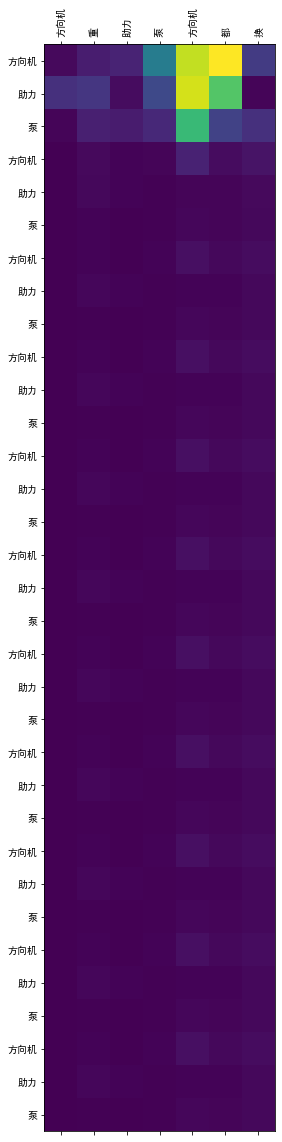

In [20]:
translate(sentence)

In [21]:
# 下半部分
assert False

AssertionError: 

In [22]:
def batch_predict(inps):
    # 判断输入长度
    batch_size=len(inps)
    # 开辟结果存储list
    preidicts=[''] * batch_size
    
    inps = tf.convert_to_tensor(inps)
    # 0. 初始化隐藏层输入
    hidden = [tf.zeros((batch_size, params["enc_units"]))]
    # 1. 构建encoder
    enc_output, enc_hidden = model.encoder(inps, hidden)
    # 2. 复制
    dec_hidden = enc_hidden
    # 3. <START> * BATCH_SIZE 
    dec_input = tf.expand_dims([vocab['<START>']] * batch_size, 1)
    
    context_vector, _ = model.attention(dec_hidden, enc_output)
    # Teacher forcing - feeding the target as the next input
    for t in range(params["max_dec_len"]):
        # 计算上下文
        context_vector, attention_weights = model.attention(dec_hidden, enc_output)
        # 单步预测
        predictions, dec_hidden = model.decoder(dec_input,
                                         dec_hidden,
                                         enc_output,
                                         context_vector)
        
        # id转换 贪婪搜索
        predicted_ids = tf.argmax(predictions,axis=1).numpy()
        
        
        for index,predicted_id in enumerate(predicted_ids):
            preidicts[index]+= vocab_reversed[predicted_id] + ' '
        
        # using teacher forcing
        dec_input = tf.expand_dims(predicted_ids, 1)

    results=[]
    for preidict in preidicts:
        # 去掉句子前后空格
        preidict=preidict.strip()
        # 句子小于max len就结束了 截断
        if '<STOP>' in preidict:
            # 截断stop
            preidict=preidict[:preidict.index('<STOP>')]
        # 保存结果
        results.append(preidict)
    return results

In [23]:
# 测试代码
# ds = iter(dataset)
# x,y = ds.next()
# batch_predict(x)

In [24]:
from tqdm import tqdm
import math

In [25]:
def model_predict(data_X, batch_size):
    # 存储结果
    results=[]
    # 样本数量
    sample_size=len(data_X)
    # batch 操作轮数 math.ceil向上取整 小数 +1
    # 因为最后一个batch可能不足一个batch size 大小 ,但是依然需要计算  
    steps_epoch = math.ceil(sample_size/batch_size)
    # [0,steps_epoch)
    for i in tqdm(range(steps_epoch)):
        batch_data = data_X[i*batch_size:(i+1)*batch_size]
        results+=batch_predict(batch_data)
    return results

In [ ]:
%%time
results=model_predict(train_x[:sample_num+1],batch_size=4)

  3%|██▌                                                                         | 689/20736 [04:13<2:14:52,  2.48it/s]